In [1]:
import os
import time
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
# import audtorch
import torch
from torch import nn
from torch.nn.utils.rnn import *
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [ ]:
!nvidia-smi

Sat Dec  5 00:13:43 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    35W / 250W |    897MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Connecting GDrive

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
%cd /content/gdrive/My\ Drive/Colab/IDL_Final_Project/new  
# %cd /content/gdrive/My\ Drive/IDL_Final_Project/new  

/content/gdrive/.shortcut-targets-by-id/1Sr9hCVVWERdsdT-sePtsjuVIxzvSrDI1/Colab/IDL_Final_Project/new


## Loading data

In [5]:
dev_data = np.load("dev_data.npy",allow_pickle=True)  
dev_labels = np.load("dev_labels.npy",allow_pickle=True)

# Labels columns: age, height, gender
# age: years, height: centimeters, gender: 1-male, 0-female
# dev_labels[0]
# >> array([27.  ,  167.64,    0.  ])

In [6]:
# for labels in dev_labels:
#   print(labels[0], labels[-1])
dev_data.shape

(997, 40, 2451)

In [7]:
train_data, test_data, train_labels, test_labels = train_test_split(dev_data, dev_labels, test_size=0.25, random_state=1)

In [8]:
train_data.shape

(747, 40, 2451)

In [9]:
# # Shuffling data
# train_indices = np.random.permutation(len(train_data))
# train_data = train_data[train_indices]
# train_labels = train_labels[train_indices]

# test_indices = np.random.permutation(len(test_data))
# test_data = test_data[test_indices]
# test_labels = test_labels[test_indices]

In [10]:
male_train_labels = train_labels[train_labels[:,-1] == 1]
m_tr_avg_age = male_train_labels[:,0].mean()

female_train_labels = train_labels[train_labels[:,-1] == 0]
f_tr_avg_age = female_train_labels[:,0].mean()

print("Female's avg age: ", f_tr_avg_age)
print("Male's avg age: ", m_tr_avg_age)

Female's avg age:  33.042929292929294
Male's avg age:  32.629629629629626


In [11]:
male_test_labels = test_labels[test_labels[:,-1] == 1]
m_test_avg_age = male_test_labels[:,0].mean()

female_test_labels = test_labels[test_labels[:,-1] == 0]
f_test_avg_age = female_test_labels[:,0].mean()

print("Female's avg age: ", m_test_avg_age)
print("Male's avg age: ", f_test_avg_age)

Female's avg age:  32.477064220183486
Male's avg age:  35.787234042553195


In [12]:
# Changing age to the average
# tr_labels = train_labels.copy()

# for idx in range(tr_labels.shape[0]):
  
#   if tr_labels[idx, -1] == 1:
#     tr_labels[idx, 0] = m_avg
#   else:
#     tr_labels[idx, 0] = f_avg

tes_labels = test_labels.copy()
for idx in range(tes_labels.shape[0]):
  
  if tes_labels[idx, -1] == 1:
    tes_labels[idx, 0] = m_tr_avg_age
  else:
    tes_labels[idx, 0] = f_tr_avg_age

Normalizing training Labels to have zero mean and unit standard deviation

In [13]:
# tr_labels[:,:-1] = (tr_labels[:,:-1] - tr_labels[:,:-1].mean(axis=0))/tr_labels[:,:-1].std(axis=0)

# tes_labels[:,:-1] = (tes_labels[:,:-1] - tes_labels[:,:-1].mean(axis=0))/tes_labels[:,:-1].std(axis=0)

## Dataset

In [14]:
class CustomDataset(Dataset):
  def __init__(self,data,labels=None):

    lens = [utter.shape[0] for utter in data]
    max_lens = max(lens)

    pad_above = 0; pad_below = 0
    pad_left = 0; pad_right = 0
    
    self.X = []

    for utter in data:
      utter = np.pad(utter, pad_width=((pad_above, max_lens-utter.shape[0]),(pad_left, pad_right)))
      utter = torch.from_numpy(utter)
      # utter = utter.T  # (64, 336)

      self.X.append(utter.type(torch.float32))

    # self.X = [torch.from_numpy(d) for d in data]

    if labels is not None:
      self.y = torch.from_numpy(labels) 
  
  def __len__(self):
    return len(self.X)

  def __getitem__(self,idx):
    X = self.X[idx]

    if self.y is not None:
      y = self.y[idx]

      return X, y
    else:
      return X, None

## Dataloader

### Collate Function

In [15]:
def collate_fn(batch_data):
    inputs, targets = zip(*batch_data)

    inp_lens = [seq.size(0) for seq in inputs]

    inputs = [input.type(torch.float32) for input in inputs]     

    padded_inputs = pad_sequence(inputs, batch_first=True)
    targets_cat = torch.cat(targets, 0).type(torch.float32)

    return padded_inputs, inp_lens, targets_cat

### DataLoaders

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # Training
# batch_size = 128

# train_dataset = CustomDataset(train_data,train_labels)
# train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, 
#                           num_workers=4,collate_fn=collate_fn,drop_last=True) 

# # Validation
# validation_dataset = CustomDataset(test_data, tes_labels)  #test_labels: age is the average age for corresponding to the gender in training data
# validation_loader = DataLoader(validation_dataset, shuffle=False, 
#                                batch_size=batch_size, num_workers=4, 
#                                collate_fn=collate_fn,drop_last=True)


# Training
batch_size = 64

train_dataset = CustomDataset(train_data,train_labels)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, 
                          num_workers=4,drop_last=True) 

# Validation
val_dataset = CustomDataset(test_data, tes_labels)  #test_labels: age is the average age for corresponding to the gender in training data
validation_loader = DataLoader(val_dataset, shuffle=False,batch_size=batch_size, 
                               num_workers=4, drop_last=True)

In [17]:
# in_channels = 64
# out_channels = 128
# k_sz = 3 

# cnn = nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=k_sz, stride=2, padding=0, bias=False)
# pool = nn.AvgPool1d(3, stride=2)
# linear = nn.Linear(out_channels , 64)

# lstm = nn.LSTM(
#             input_size = 64,
#             hidden_size = 256,
#             num_layers = 2, 
#             dropout = 0.3,
#             bidirectional = False,
#             batch_first = True
#         )

# for inputs, labels in validation_loader:
#   inp = inputs

#   print("in",inp.size())
#   print("in labels",labels.size())

#   out = cnn(inp)
#   print("CNN out", out.size())

#   out = pool(out)
#   print("Pool out", out.size())

#   out = linear(out.permute(0, 2,1))
#   print("Linear out", out.size())

#   out, _ = lstm(out)
#   print("LSTM out", out.size())

#   break

## Model

In [18]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, dropout, batch_size, layers=1, output_size=1, bd=False):
        super(Model, self).__init__()

        self.num_layers = layers
        self.batch_size = batch_size
        self.hidden_size = hidden_size

        self.num_d = 1  # Number of directions


        in_channels = input_size #64
        out_channels = 128
        k_sz = 3 

        if bd:
          self.num_d = 2

        self.cnn = nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=k_sz, stride=1, padding=0, bias=False)
        self.bn = nn.BatchNorm1d(out_channels)
        self.avg_pool = nn.AvgPool1d(3, stride=2)
        
        self.linear = nn.Linear(out_channels , 64)

        self.lstm = nn.LSTM(
            input_size = 64,
            hidden_size = hidden_size,
            num_layers = layers, 
            dropout = dropout,
            bidirectional = bd,
            batch_first = True
        )
        
        self.fc2 = nn.Linear(hidden_size * self.num_d, output_size)

        self.init_weights()
    
    def forward(self, batch_data,lens,hidden=None): 
  
        # ps = pack_padded_sequence(batch_data, batch_first=True, lengths=lens, enforce_sorted=False)

        # Forward propagate LSTM

        emb = self.cnn(batch_data)  # emb => (batch_size, out_channels, Lout)
        # emb = F.relu(self.bn(emb))
        emb = self.avg_pool(emb)   

    
        out = self.linear(emb.permute(0, 2,1))


        # out, hidden = self.lstm(out)
        
        #out = out.permute(1,0,2) #asantewaa change
        #print("before lstm",out.shape)#,hidden)
        if hidden is not None:
          out, hidden = self.lstm(out, hidden)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        else:
          out, hidden = self.lstm(out)

        # out, out_lens = pad_packed_sequence(out, batch_first=True)
        #out = out.permute(1,0,2)
        #print("from lstm",out.shape)
        # Decode the hidden state of the last time step
        last_time_step_out = out[:,-1] #out[-1]  # out[-1] is for taking output at the last time step
        # out = self.fc1(last_time_step_out)
        out = self.fc2(last_time_step_out)

        return out.view(-1), hidden

    def init_hidden(self):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.num_layers * self.num_d, self.batch_size, self.hidden_size).zero_().to(device),
                    weight.new(self.num_layers * self.num_d, self.batch_size, self.hidden_size).zero_().to(device))
        return hidden

    def init_weights(self):
      for name, param in self.lstm.named_parameters():
        if 'bias' in name:
          nn.init.constant_(param, 0.0)
        elif 'weight' in name:
          nn.init.xavier_normal_(param)

## Training

### Validate

In [19]:
def validate(model,validation_loader):
  model.eval()
  running_loss_v = 0.0
  correct_v = 0
  total_v = 0

  with torch.no_grad():
    # for batch_idx, (X, inp_len, y) in enumerate(validation_loader):
    for batch_idx, (X, y) in enumerate(validation_loader):
      inp_len = 0

      X = X.to(device)
      y = y.to(device)

      age_prediction, _ = model(X,inp_len)

      loss = criterion(age_prediction,y[:,0])

      preds = age_prediction.cpu().numpy()

      # loss2 = criterion(height_prediction,y[:,1])

      # loss = loss1 + loss2  # Adding for MTL

      running_loss_v += loss.item()

      # print('Batch val loss', loss.item())
      total_v += y.size(0)


      torch.cuda.empty_cache()
      del X; del y
      del age_prediction #; del height_prediction
      # del loss1; del loss2
      del loss


  avg_loss_v = running_loss_v / len(validation_loader)

  return avg_loss_v

### Train method

In [27]:
def train():

  total_loss = []
  running_loss = 0.0
  total = 0

  val_avg_loss = []
  train_avg_loss_list = []

  for epoch in range(NUM_EPOCHS):
    print("EPOCH #",epoch + 1)
    
    model.train()  # Re-enabling training
    
    start = time.time()

    hidden = model.init_hidden() #asantewaa change

    # for batch_idx, (X, inp_lens, y) in enumerate(train_loader):
    for batch_idx, (X, y) in enumerate(train_loader):
      
      inp_lens = 0

      hidden = tuple([e.data for e in hidden])

      optimizer.zero_grad()

      X = X.to(device)
      y = y.to(device)

      t0 = time.time()
      #print("shape of x",X.shape)

      age_prediction, h = model(X, inp_lens, hidden) #asantewaa change
      hidden = h
      
      loss = criterion(age_prediction,y[:,0])

      running_loss += loss.item()
      total += y.size(0)


      if (batch_idx + 1) % 10 == 0 or (batch_idx + 1) == len(train_loader):
        print('[Batch {}]\tLoss: {}'.format(batch_idx + 1, loss.item()))
        #print(age_prediction,y[:,0])

      t1 = time.time()

      loss.backward()

      t2 = time.time()
      
      if batch_idx == 0 and epoch == 0:
        print("Model Prediction time: ", t1 - t0)
        print("Loss Backward computation time: ", (time.time() - t2))

      optimizer.step()
      # scheduler.step()
      scheduler.step(loss)


      torch.cuda.empty_cache()
      del X; del y
      del age_prediction  #; del height_prediction
      # del loss1; del loss2
      del loss

    train_avg_loss = running_loss / total

    # Validating
    t0 = time.time()
    validation_avg_loss = validate(model,validation_loader)
    running_loss/= len(train_loader)
    total_loss.append(running_loss)
    train_avg_loss_list.append(train_avg_loss)

    val_avg_loss.append(validation_avg_loss)

    if epoch == 0:
      print("Validation time: ", (time.time() - t0))
      print("Epoch duration time: ", (time.time() - start))
      print("*" * 30)
      print("")

    print('Epoch [%d] [train] loss: %.8f' %(epoch + 1, train_avg_loss))
    print('[running] loss: %.8f' % (running_loss))
    print('[valid] loss: %.8f' % (validation_avg_loss))
    print("-" * 30)

    # if len(val_avg_loss) >= 2 and val_avg_loss[-1] > val_avg_loss[-2]:
    #   print("Stopped. Model started overfitting data")
    #   break

  return val_avg_loss

### main

In [21]:
train_dataset.__getitem__(0)[0].shape[0]

40

In [29]:
DEFAULT_RANDOM_SEED = 2222

torch.manual_seed(DEFAULT_RANDOM_SEED)
# np.random.seed(DEFAULT_RANDOM_SEED)
if device == "cuda":
  torch.cuda.manual_seed(DEFAULT_RANDOM_SEED)

NUM_EPOCHS = 20 #100

learning_rate = 1e-01  # Best with ADAM: 1e-01

input_size = train_dataset.__getitem__(0)[0].shape[0] #64
hidden_size = 256
dropout = 0.5
nlayers = 2
bidirectional = True#False

model = Model(input_size,hidden_size,dropout, batch_size,layers=nlayers, bd=bidirectional)

model.to(device)

criterion = nn.L1Loss() #nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate, weight_decay=5e-06)
# optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate, momentum=0.9)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
    factor=0.1, patience=20, threshold=0.01, verbose=True)

val_avg_loss = train()

EPOCH # 1
Model Prediction time:  0.27059078216552734
Loss Backward computation time:  0.00040340423583984375
[Batch 10]	Loss: 8.18012323975563
[Batch 11]	Loss: 9.51640272140503
Validation time:  0.75003981590271
Epoch duration time:  7.953308582305908
******************************

Epoch [1] [train] loss: 0.25186195
[running] loss: 16.11916512
[valid] loss: 12.74453933
------------------------------
EPOCH # 2
[Batch 10]	Loss: 8.141199111938477
[Batch 11]	Loss: 9.24107739329338
Epoch [2] [train] loss: 0.08838679
[running] loss: 11.31350919
[valid] loss: 8.46681711
------------------------------
EPOCH # 3
[Batch 10]	Loss: 9.000821232795715
[Batch 11]	Loss: 9.299712091684341
Epoch [3] [train] loss: 0.05596121
[running] loss: 10.74455227
[valid] loss: 6.45835502
------------------------------
EPOCH # 4
Epoch    37: reducing learning rate of group 0 to 1.0000e-02.
[Batch 10]	Loss: 9.748963475227356
[Batch 11]	Loss: 12.475015193223953
Epoch [4] [train] loss: 0.05501146
[running] loss: 14.0

In [23]:
# from time import time
# torch.save({
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'lr': learning_rate,
#             'hidden_size': hidden_size,
#             'dropout': dropout,
#             'layers': nlayers,
#             'val_loss':val_avg_loss[-1] 
#         }, "Model_avg_age_"+str(time())+".model")

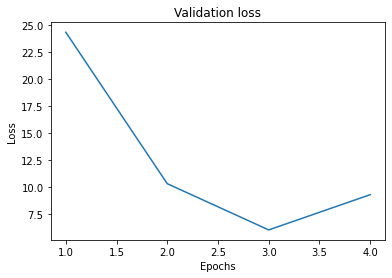

<Figure size 432x288 with 0 Axes>

In [24]:
fig = plt.gcf()

plt.plot(list(range(1,len(val_avg_loss) + 1)), val_avg_loss)
plt.xlabel("Epochs")
plt.ylabel('Loss')
plt.title('Validation loss')

plt.show()
plt.draw()
# fig.savefig('avg_age_loss_lr1_{}_data_{}.png'.format(learning_rate,len(train_labels)), dpi=100)

## L1 Loss and L2 Loss on Test data

In [30]:
model.eval()

predictions = []
targets = []

with torch.no_grad():
  for batch_idx, (X, y) in enumerate(validation_loader):

    X = X.to(device)

    output, hidden = model(X,0)

    pred = output.cpu().numpy()

    predictions.extend(pred.tolist())
    targets.extend(y[:,[0,-1]].numpy().tolist())

    torch.cuda.empty_cache()
    del X; del hidden
    del output

In [31]:
predictions = torch.Tensor(predictions)
targets = torch.Tensor(targets)

mae_loss = nn.L1Loss() 
mse_loss = nn.MSELoss()

l1 = mae_loss(predictions, targets[:,0])
l2 = mse_loss(predictions, targets[:,0])

print("MAE: ", l1.item())
print("MSE: ", l2.item())

MAE:  8.669818878173828
MSE:  80.24198150634766


### MALE

In [32]:
index = targets[:,1] == 1

l1 = mae_loss(predictions[index], targets[index][:,0])
l2 = mse_loss(predictions[index], targets[index][:,0])

print("Avg: ", predictions[index].numpy().mean())
print("MAE: ", l1.item())
print("MSE: ", l2.item())

Avg:  24.130844
MAE:  8.498785972595215
MSE:  76.38325500488281


### FEMALE

In [33]:
index = targets[:,1] == 0

l1 = mae_loss(predictions[index], targets[index][:,0])
l2 = mse_loss(predictions[index], targets[index][:,0])

print("Avg: ", predictions[index].numpy().mean())
print("MAE: ", l1.item())
print("MSE: ", l2.item())

Avg:  24.250944
MAE:  8.791985511779785
MSE:  82.99821472167969


## Losses with Actual Test labels

In [34]:
validation_dataset = CustomDataset(test_data, test_labels)#test_labels
test_loader = DataLoader(validation_dataset, shuffle=False, 
                               batch_size=batch_size, num_workers=4)

In [35]:
model.eval()

predictions = []
targets = []

with torch.no_grad():
  for batch_idx, (X, y) in enumerate(test_loader):

    X = X.to(device)

    output, hidden = model(X,0)

    pred = output.cpu().numpy()

    predictions.extend(pred.tolist())
    targets.extend(y[:,[0,-1]].numpy().tolist())

    torch.cuda.empty_cache()
    del X; del hidden
    del output

In [36]:
print(min(predictions))
print(max(predictions))
# print(predictions.mean())
# predictions

22.355173110961914
31.769948959350586


In [37]:
print(min(targets))
print(max(targets))
# print(targets[:, 0].mean())

[18.0, 0.0]
[82.0, 0.0]


In [38]:
predictions = torch.Tensor(predictions)
targets = torch.Tensor(targets)

mae_loss = nn.L1Loss() 
mse_loss = nn.MSELoss()

### Male

In [39]:
index = targets[:,1] == 1

l1 = mae_loss(predictions[index], targets[index][:,0])
l2 = mse_loss(np.round(predictions[index]), targets[index][:,0])
print(targets[index][:,0])
print(np.round(predictions[index]))
#print("Avg: ", predictions[index].numpy().mean())
print("MAE: ", l1.item())
print("MSE: ", l2.item())

tensor([29., 35., 58., 31., 24., 28., 24., 29., 25., 19., 23., 29., 26., 25.,
        23., 29., 81., 31., 22., 29., 60., 32., 69., 22., 22., 48., 26., 29.,
        24., 65., 24., 20., 23., 29., 42., 20., 26., 23., 29., 29., 22., 30.,
        20., 29., 29., 41., 23., 81., 23., 21., 54., 46., 25., 48., 20., 24.,
        24., 63., 25., 33., 58., 35., 26., 25., 23., 32., 24., 23., 36., 23.,
        22., 26., 22., 48., 23., 26., 23., 22., 41., 25., 22., 49., 27., 53.,
        24., 24., 23., 29., 31., 26., 58., 26., 24., 68., 27., 26., 31., 49.,
        33., 53., 30., 25., 54., 26., 24., 30., 57., 24., 21.])
tensor([23., 23., 27., 23., 23., 23., 24., 24., 30., 23., 23., 23., 23., 23.,
        23., 23., 23., 23., 23., 27., 26., 23., 30., 25., 25., 24., 27., 24.,
        23., 23., 25., 23., 23., 28., 28., 23., 23., 23., 23., 23., 23., 23.,
        23., 23., 23., 27., 23., 23., 23., 23., 30., 23., 23., 23., 23., 26.,
        23., 24., 23., 31., 23., 23., 23., 23., 23., 23., 23., 23., 23., 23.,


### Female

In [40]:
index = targets[:,1] == 0

l1 = mae_loss(predictions[index], targets[index][:,0])
l2 = mse_loss(predictions[index], targets[index][:,0])

#print("Avg: ", predictions[index].numpy().mean())
print("MAE: ", l1.item())
print("MSE: ", l2.item())

MAE:  13.023809432983398
MSE:  380.456298828125
